# Multivariate Forecasting  
This notebook outlines an example of scalecast using multiple series to forecast one another using scikit-learn models.

The data is available on Kaggle: https://www.kaggle.com/datasets/neuromusic/avocado-prices  
See the blog post: https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

In [2]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

We will be forecasting the organic and conventional avocado sales from California only.

In [3]:
data_cali = data.loc[data['region'] == 'California']
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']

## Choose Models and Import Validation Grids

In [4]:
# download template validation grids (will not overwrite existing Grids.py file by default)
models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

## EDA

### Plot

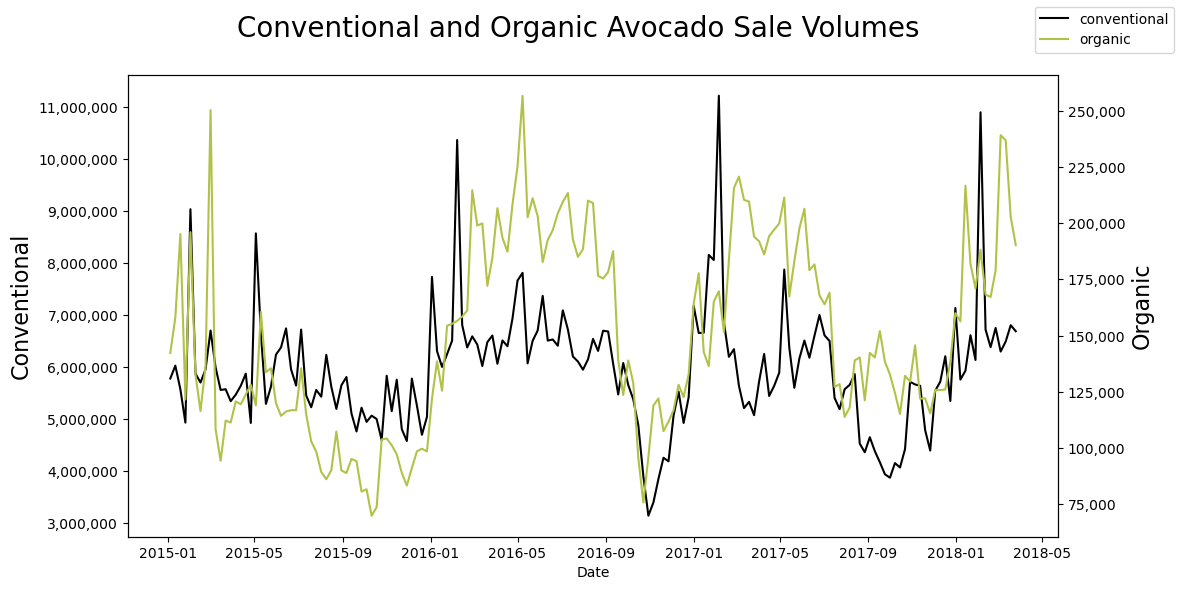

In [5]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_con,
    label='conventional',
    ax=ax,
    color='black',
    legend=False
)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_org,
    label='organic',
    ax=ax2,
    color='#B2C248',
    legend=False
)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()

### Examine Correlation between the series

In [6]:
corr = np.corrcoef(data_cali_org['Total Volume'].values,data_cali_con['Total Volume'].values)[0,1]
print('{:.2%}'.format(corr))

48.02%


### Load into Forecaster from scalecast

In [7]:
fcon = Forecaster(
    y=data_cali_con['Total Volume'],
    current_dates = data_cali_con['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
fcon

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [8]:
forg = Forecaster(
    y=data_cali_org['Total Volume'],
    current_dates = data_cali_org['Date'],
    test_length = .2,
    future_dates = 52,
    validation_length = 4,
    metrics = ['rmse','r2'],
    cis = True,
)
forg

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=[]
    TestLength=33
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### ACF and PACF Plots

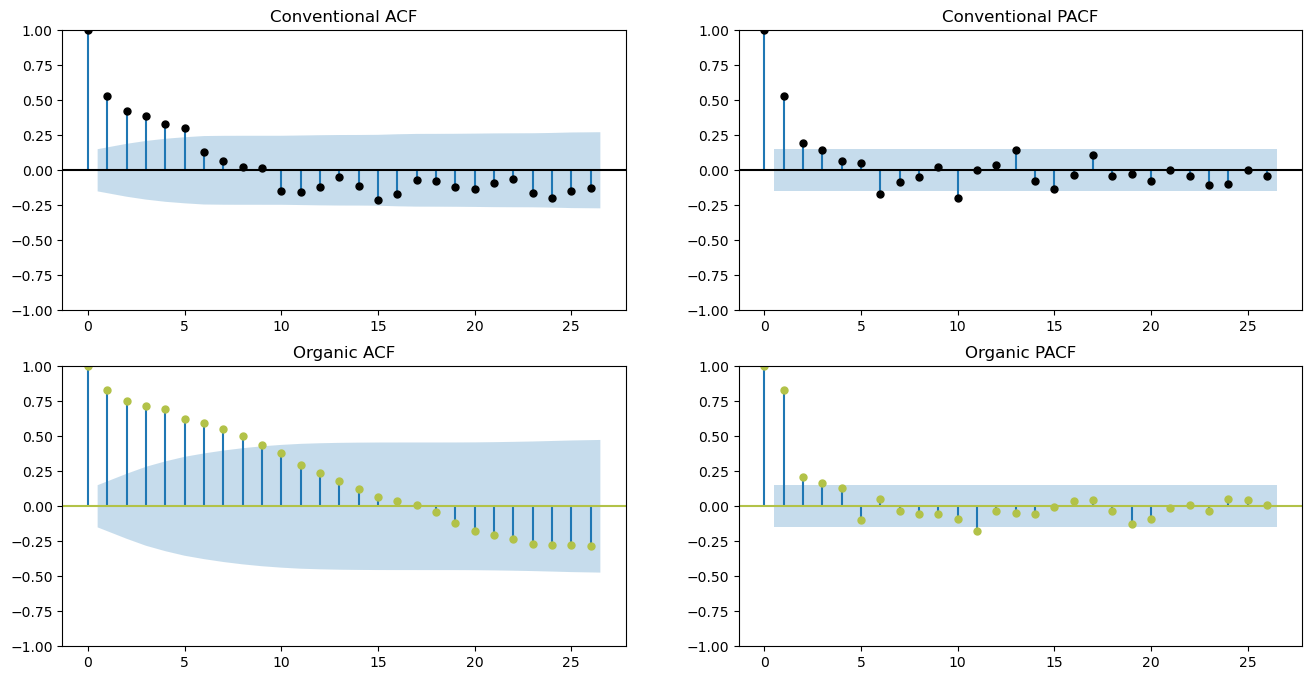

In [9]:
figs, axs = plt.subplots(2, 2,figsize=(16,8))
fcon.plot_acf(
    ax=axs[0,0],
    title='Conventional ACF',
    lags=26,
    color='black'
)
fcon.plot_pacf(
    ax=axs[0,1],
    title='Conventional PACF',
    lags=26,
    color='black',
    method='ywm'
)
forg.plot_acf(
    ax=axs[1,0],
    title='Organic ACF',
    lags=26,
    color='#B2C248'
)
forg.plot_pacf(
    ax=axs[1,1],
    title='Organic PACF',
    lags=26,
    color='#B2C248',
    method='ywm'
)
plt.show()

### Seasonal Decomposition Plots

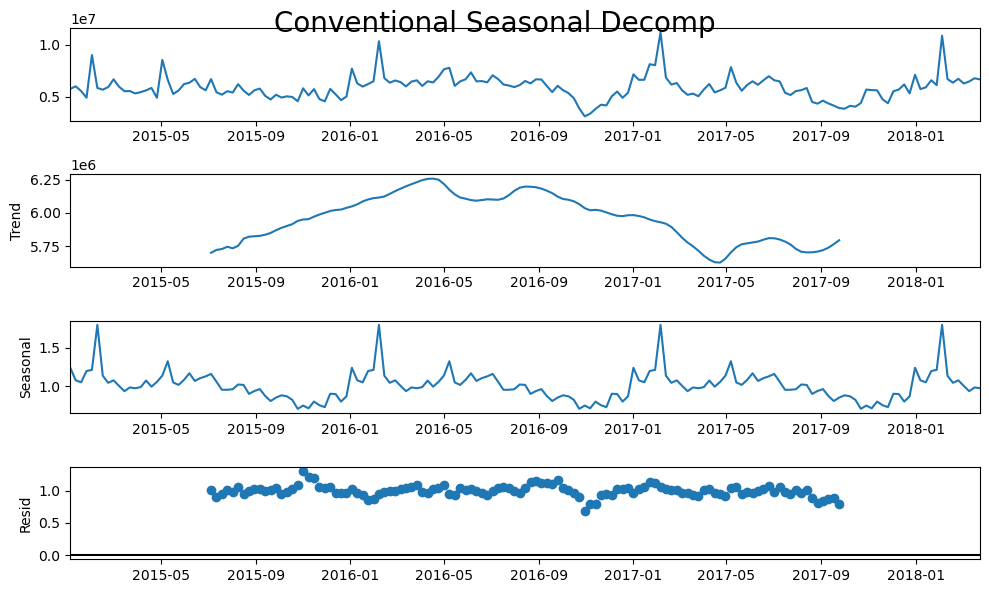

In [10]:
plt.rc("figure",figsize=(10,6))
fcon.seasonal_decompose(model='mul').plot()
plt.suptitle('Conventional Seasonal Decomp',size=20)
plt.show()

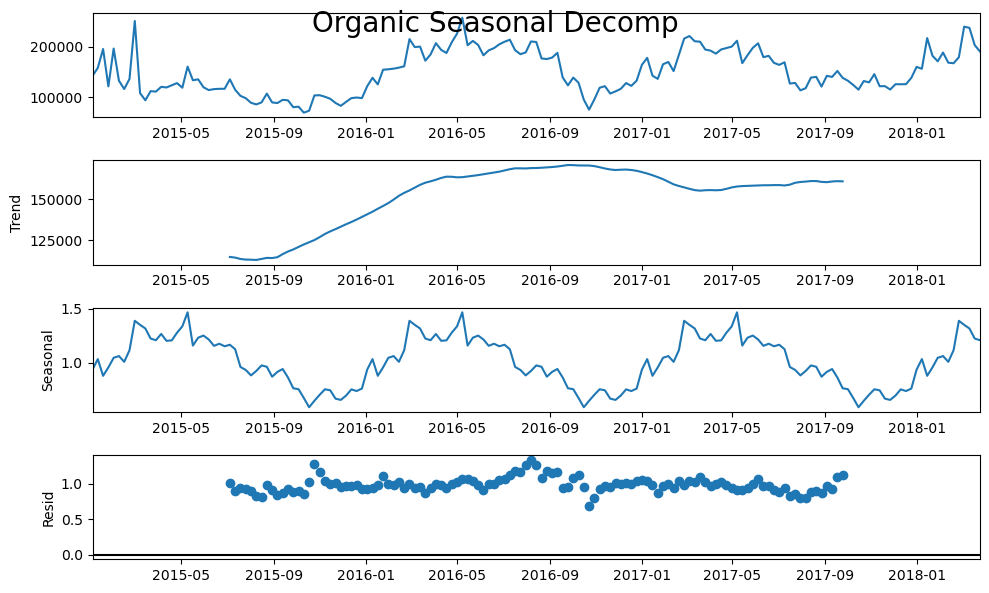

In [11]:
forg.seasonal_decompose(model='mul').plot()
plt.suptitle('Organic Seasonal Decomp',size=20)
plt.show()

### Check Stationarity

In [12]:
critical_pval = 0.05
print('-'*100)
print('Conventional Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = fcon.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)
print('Organic Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = forg.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Conventional Augmented Dickey-Fuller results:
the test-stat value is: -3.35
the p-value is 0.0128
the series is stationary
----------------------------------------------------------------------------------------------------
Organic Augmented Dickey-Fuller results:
the test-stat value is: -2.94
the p-value is 0.0404
the series is stationary
----------------------------------------------------------------------------------------------------


## Scalecast - Univariate

### Load Objects with Xvars:
- Find best combination of trend, lags, and seasonality monitoring the validation set (4 observations before the test set)

In [13]:
for f in (fcon,forg):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        irr_cycles = [26], # try irregular semi-annual seaosnality
    )
    print(f)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28']
    TestLength=33
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)
Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2']
    TestLength=33
    ValidationLength=4
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95


### Tune and Forecast with Selected Models
- Find optimal hyperparameters using the four out-of-sample observations then test results on test set

#### Conventional

In [14]:
fcon.tune_test_forecast(models,feature_importance=True)
fcon.set_estimator('combo')
fcon.manual_forecast(how='weighted')

2023-04-01 22:04:19.085308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


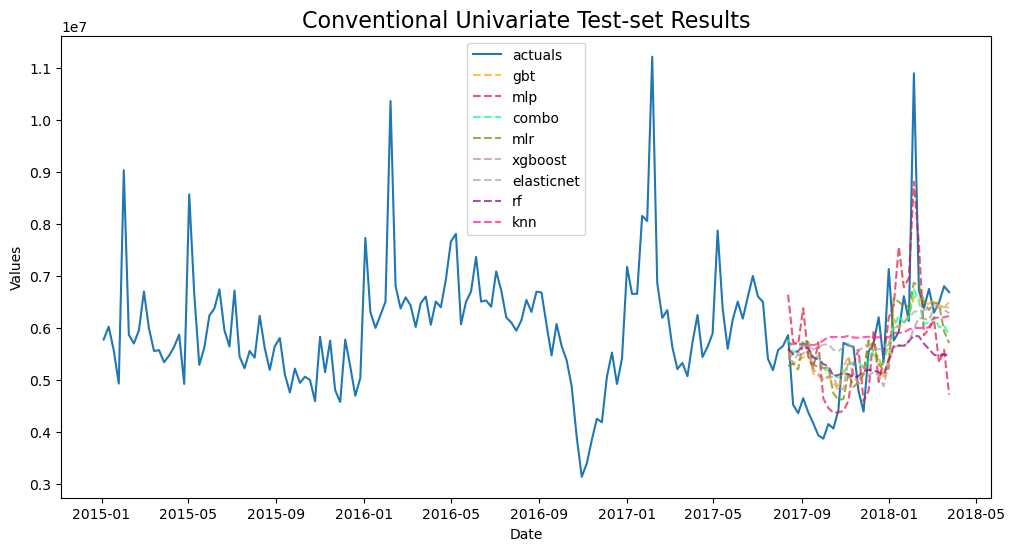

In [15]:
fcon.plot_test_set(order_by='TestSetRMSE')
plt.title('Conventional Univariate Test-set Results',size=16)
plt.show()

#### Organic

In [16]:
forg.tune_test_forecast(models,feature_importance=True)
forg.set_estimator('combo')
forg.manual_forecast(how='weighted')

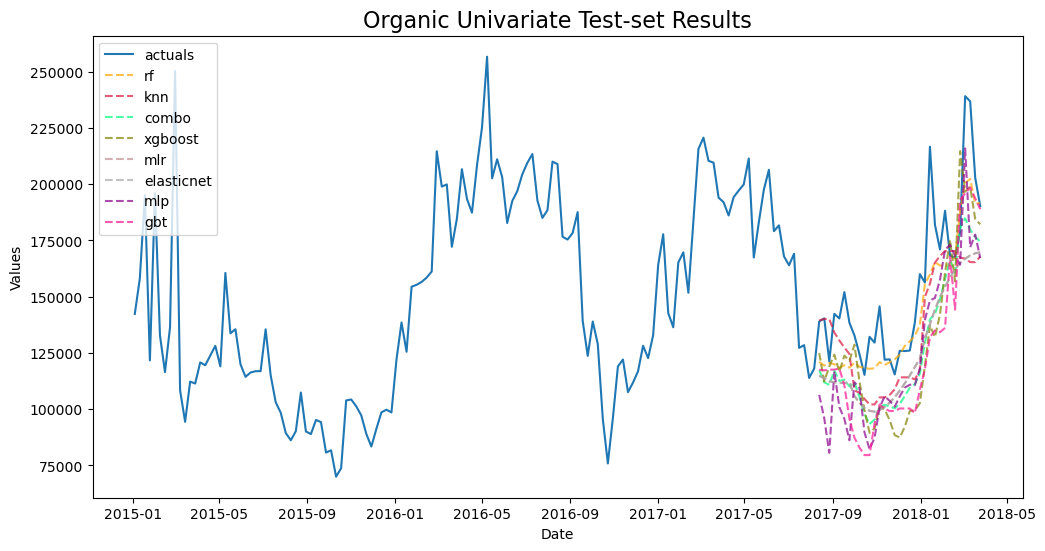

In [17]:
forg.plot_test_set(order_by='TestSetRMSE')
plt.title('Organic Univariate Test-set Results',size=16)
plt.show()

### Feature Importance
By default, scalecast uses permutation feature importance from ELI5. After calling a model, the model object from sklearn is available using `f.regr` and that object can be used to export other types of feature importances.

#### Conventional
- Best model: gbt

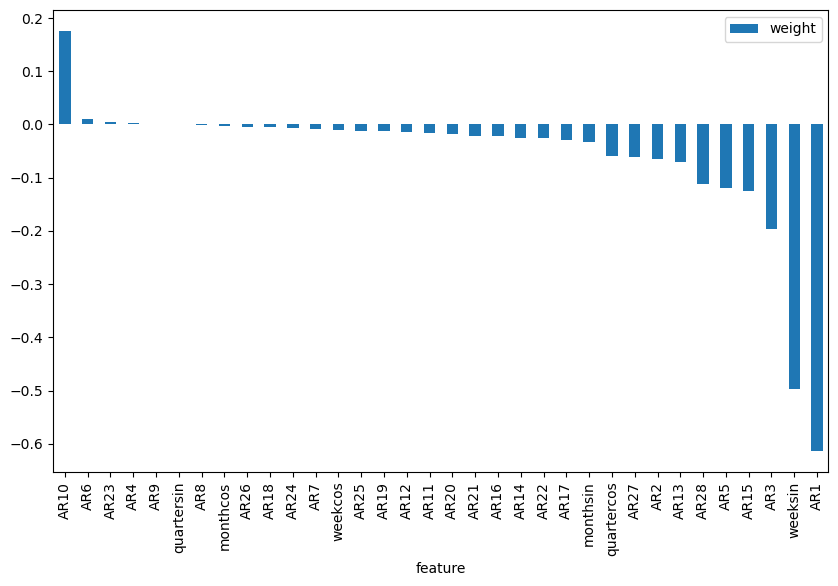

In [18]:
fcon.export_feature_importance('gbt').plot.bar(y='weight')
plt.show()

#### Organic
- Best model: knn

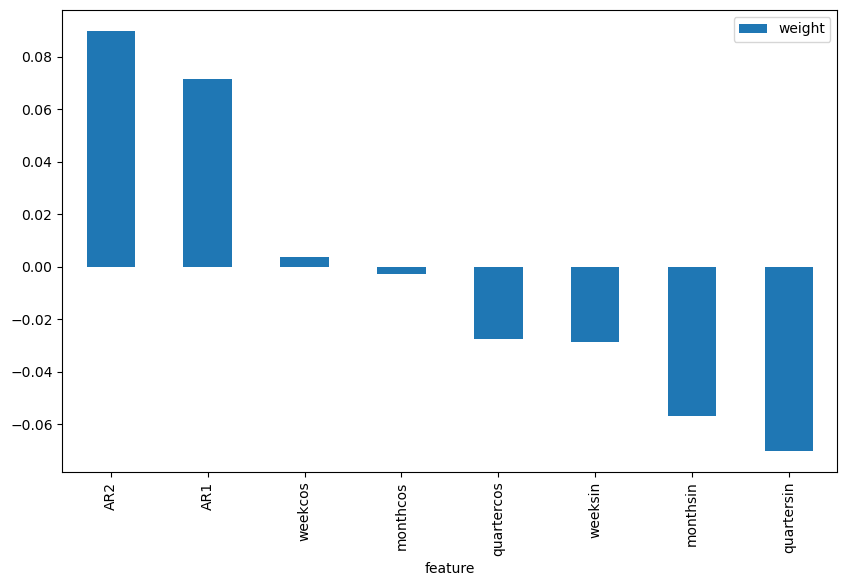

In [19]:
forg.export_feature_importance('knn').plot.bar(y='weight')
plt.show()

### Model Summaries

In [20]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'Conventional':fcon,'Organic':forg},determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'Series',
        'Integration',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,Integration,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,gbt,Conventional,0,1001833.1842,0.4503,86246.6697,0.9948,True
1,mlp,Conventional,0,1048877.2361,0.3975,637.1443,1.0000,False
2,combo,Conventional,0,1066211.4310,0.3774,369630.9071,0.9054,False
3,mlr,Conventional,0,1067888.7369,0.3754,759892.3368,0.6001,False
4,xgboost,Conventional,0,1151971.6516,0.2732,1027.5170,1.0000,False
5,elasticnet,Conventional,0,1175262.8882,0.2435,884446.5567,0.4583,False
6,rf,Conventional,0,1277129.3404,0.1067,356643.5763,0.9119,False
7,knn,Conventional,0,1284430.0341,0.0964,1023470.2968,0.2746,False
8,rf,Organic,0,19077.4332,0.6767,12904.1486,0.9083,True
9,knn,Organic,0,27964.7341,0.3053,29499.3247,0.5206,False


Because running so many models can cause overfitting on the test set, we can check the average test error between all models to get another metric of how effective our modeling process is.

In [21]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'TestSetRMSE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for Conventional: 1134200.5628
univariate average test R2 for Conventional: 0.29
----------------------------------------------------------------------------------------------------
univariate average test MAPE for Organic: 30894.2461
univariate average test R2 for Organic: 0.13
----------------------------------------------------------------------------------------------------


These are interesting error metrics, but a lot of models, including XGBoost and GBT appear to be overfitting. Let's see if we can beat the results with a multivariate approach.

## Scalecast - Multivariate

### Set MV Parameters
- Forecast horizon already set
- Xvars already set
- Test size must be set: 20%
- Validation size must be set: 4 periods

In [22]:
mvf = MVForecaster(
    fcon,forg,
    names=['Conventional','Organic'],
    test_length = .2,
    valiation_length = 4,
    cis = True,
    metrics = ['rmse','r2'],
) # init the mvf object
mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['Conventional', 'Organic']
    ForecastLength=52
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos']
    TestLength=33
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

The lags from each Forecaster object dropped but they will be added into the multivariate models differently.

### View Series Correlation

In [23]:
mvf.corr()

,Conventional,Organic
Conventional,1.0000,0.4802
Organic,0.4802,1.0000


### View Series Correlation with each others' lags

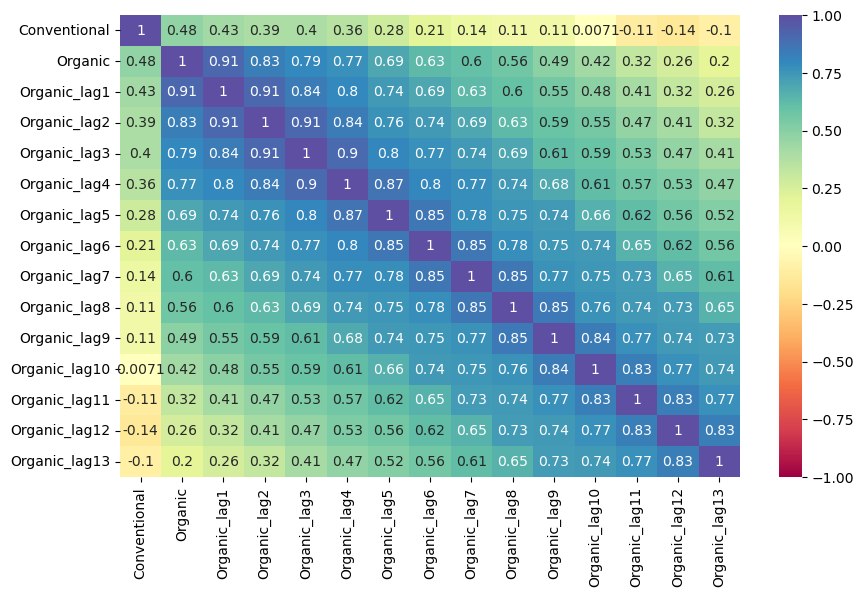

In [24]:
mvf.corr_lags(
    y='Conventional',
    x='Organic',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

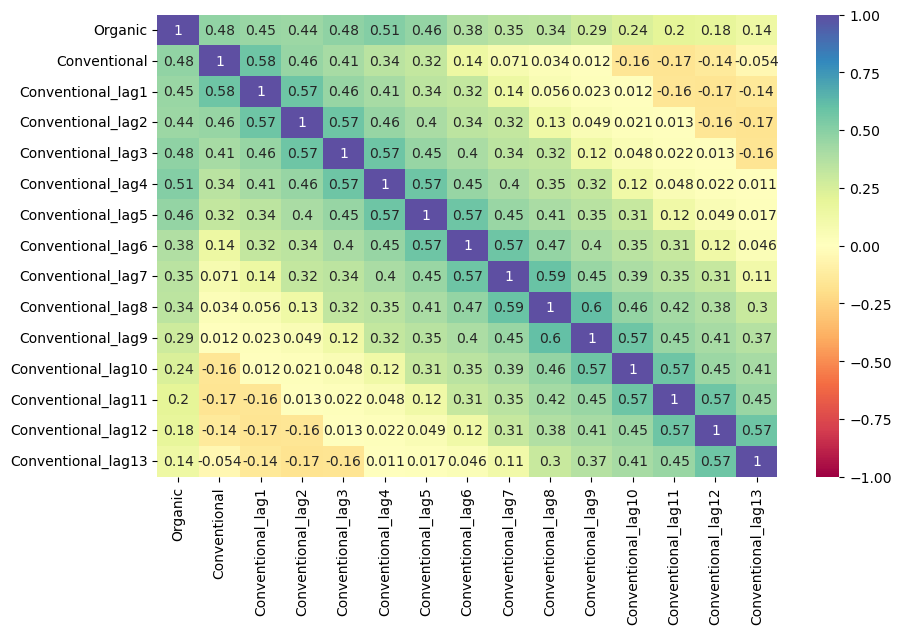

In [25]:
mvf.corr_lags(
    y='Organic',
    x='Conventional',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

### Set Optimize On
- If predicting one series is more important than predicting the other, you can use this code to let the code know to favor one over the other
- By default, it uses the mean error metrics between all series

In [26]:
# how to optimize on one series
mvf.set_optimize_on('Organic')
# how to optimize using a weighted avarage
mvf.add_optimizer_func(lambda x: x[0]*.25 + x[1]*.75,'weighted')
mvf.set_optimize_on('weighted')
# how to optimize on the average of both/all series (default)
mvf.set_optimize_on('mean')

### Tune and Test with Selected Models

In [27]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='TestSetRMSE')

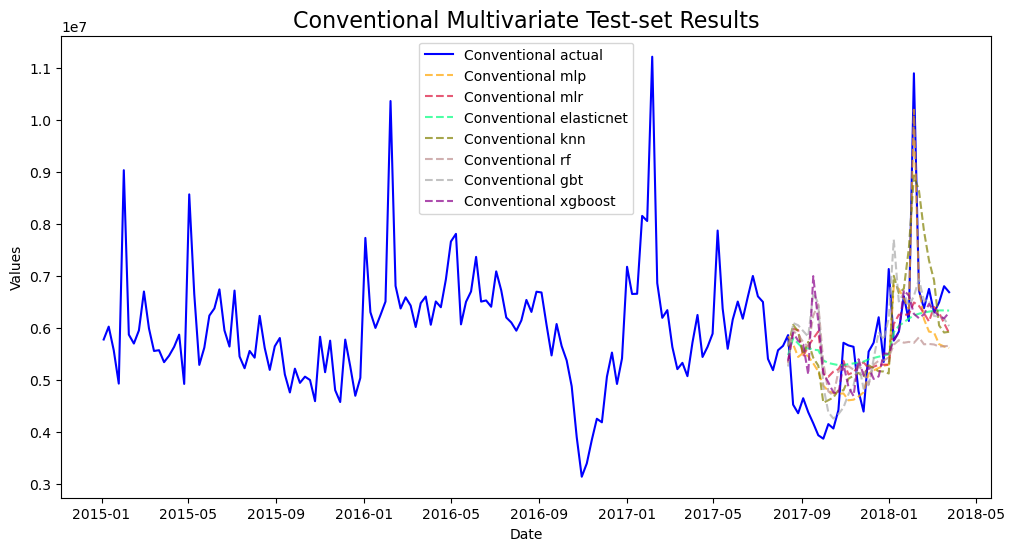

In [28]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='Conventional',put_best_on_top=True)
plt.title('Conventional Multivariate Test-set Results',size=16)
plt.show()

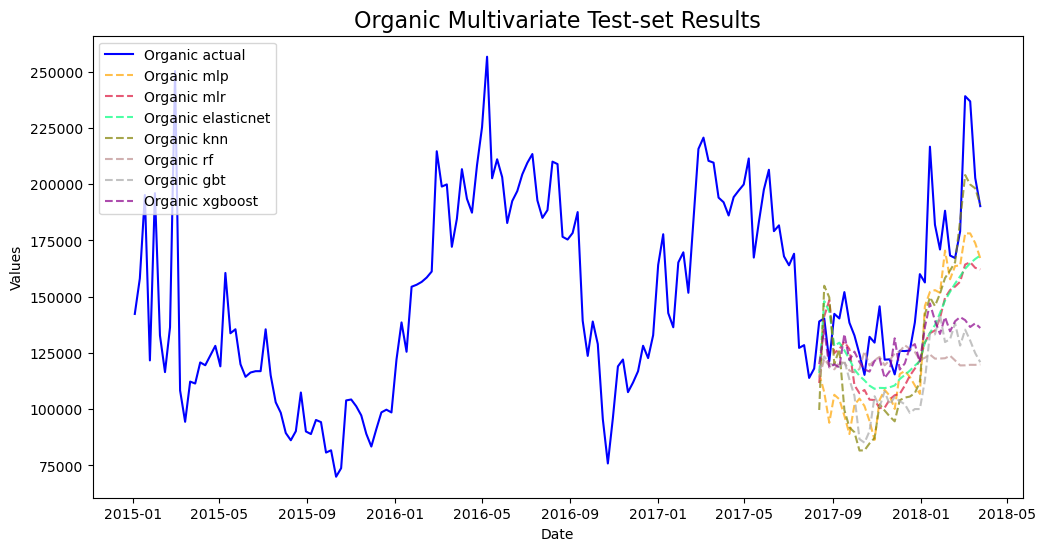

In [29]:
mvf.plot_test_set(series='Organic',put_best_on_top=True)
plt.title('Organic Multivariate Test-set Results',size=16)
plt.show()

### Export Model Summaries

In [30]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags
0,mlp,Conventional,"{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'random_state': 20}",846852.5544,0.6072,676510.3813,0.6610,1
1,mlr,Conventional,{},1178129.9499,0.2398,889233.0719,0.4209,3
2,elasticnet,Conventional,"{'alpha': 1.1, 'l1_ratio': 0.75}",1159320.7223,0.2639,911574.7801,0.3915,3
3,knn,Conventional,"{'n_neighbors': 6, 'weights': 'distance'}",1039429.0789,0.4083,0.0000,1.0000,3
4,rf,Conventional,"{'max_depth': 5, 'n_estimators': 100}",1354003.5951,-0.0041,347731.2310,0.9108,10
5,gbt,Conventional,"{'max_depth': 3, 'max_features': None}",1254590.1564,0.1379,129438.2172,0.9876,10
6,xgboost,Conventional,{'max_depth': 3},1243205.1153,0.1535,15301.7121,0.9998,13
7,mlp,Organic,"{'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'solver': 'lbfgs', 'random_state': 20}",33144.2543,0.0241,21200.7041,0.7509,1
8,mlr,Organic,{},33295.0908,0.0152,21337.2546,0.7490,3
9,elasticnet,Organic,"{'alpha': 1.1, 'l1_ratio': 0.75}",31609.1407,0.1124,22259.2878,0.7268,3


### Import a Foreign Sklearn Estimator for Ensemble Modeling

In [31]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
estimators = [
    (
        'mlr',
        LinearRegression()
    ),
    (
        'elasticnet',
        ElasticNet(
            **results.loc[
                results['ModelNickname'] == 'elasticnet',
                'HyperParams'
            ].values[0]
        )
    ),
    (
        'mlp',
        MLPRegressor(
            **results.loc[
                results['ModelNickname'] == 'mlp',
                'HyperParams'
            ].values[0]
        )
    )
]

final_estimator = KNeighborsRegressor(
    **results.loc[
        results['ModelNickname'] == 'knn',
        'HyperParams'
    ].values[0]
)

In [32]:
mvf.add_sklearn_estimator(StackingRegressor,'stacking')
mvf.set_estimator('stacking')
mvf.manual_forecast(estimators=estimators,final_estimator=final_estimator,lags=13)

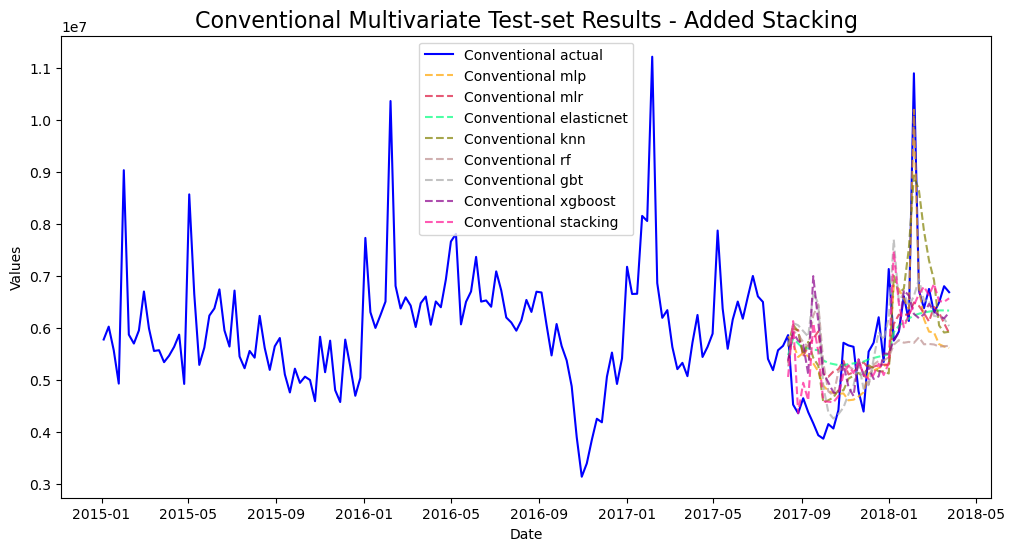

In [33]:
mvf.plot_test_set(series='Conventional',put_best_on_top=True)
plt.title('Conventional Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

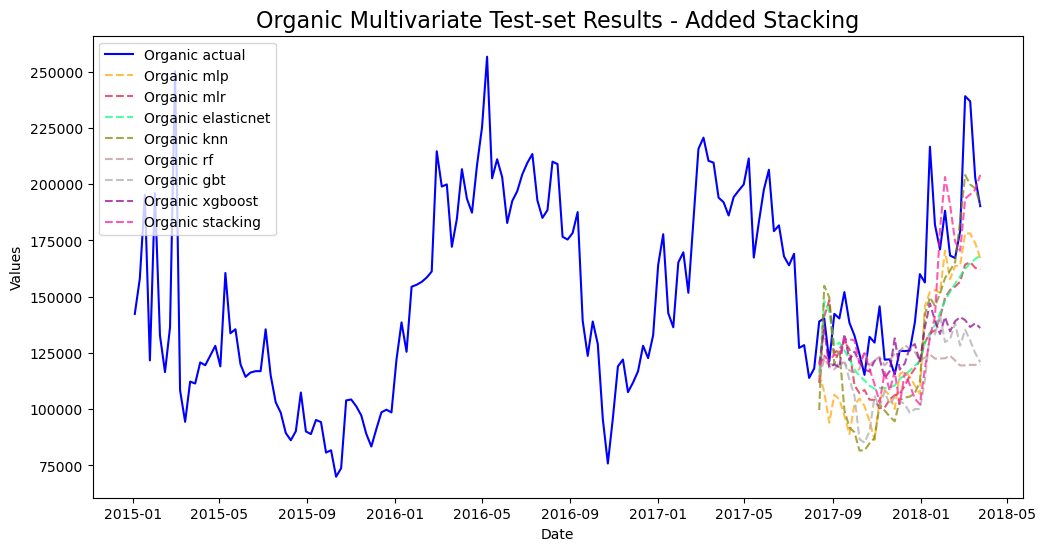

In [34]:
mvf.plot_test_set(series='Organic',put_best_on_top=True)
plt.title('Organic Multivariate Test-set Results - Added Stacking',size=16)
plt.show()

In [35]:
mvf.set_best_model(determine_best_by='TestSetRMSE')
results2 = mvf.export('model_summaries')
results2[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'LevelTestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags',
        'best_model'
    ]
]

,ModelNickname,Series,TestSetRMSE,LevelTestSetR2,InSampleRMSE,InSampleR2,Lags,best_model
0,mlp,Conventional,846852.5544,0.6072,676510.3813,0.6610,1,True
1,mlr,Conventional,1178129.9499,0.2398,889233.0719,0.4209,3,False
2,elasticnet,Conventional,1159320.7223,0.2639,911574.7801,0.3915,3,False
3,knn,Conventional,1039429.0789,0.4083,0.0000,1.0000,3,False
4,rf,Conventional,1354003.5951,-0.0041,347731.2310,0.9108,10,False
5,gbt,Conventional,1254590.1564,0.1379,129438.2172,0.9876,10,False
6,xgboost,Conventional,1243205.1153,0.1535,15301.7121,0.9998,13,False
7,stacking,Conventional,1116998.8722,0.3167,847248.7956,0.4787,13,False
8,mlp,Organic,33144.2543,0.0241,21200.7041,0.7509,1,True
9,mlr,Organic,33295.0908,0.0152,21337.2546,0.7490,3,False


In [36]:
print('-'*100)
for series in results2['Series'].unique():
    print('multivariate average test MAPE for {}: {:.4f}'.format(series,results2.loc[results2['Series'] == series,'TestSetRMSE'].mean()))
    print('multivariate average test R2 for {}: {:.2f}'.format(series,results2.loc[results2['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Conventional: 1149066.2556
multivariate average test R2 for Conventional: 0.27
----------------------------------------------------------------------------------------------------
multivariate average test MAPE for Organic: 36173.4733
multivariate average test R2 for Organic: -0.20
----------------------------------------------------------------------------------------------------


### Plot Final Forecasts

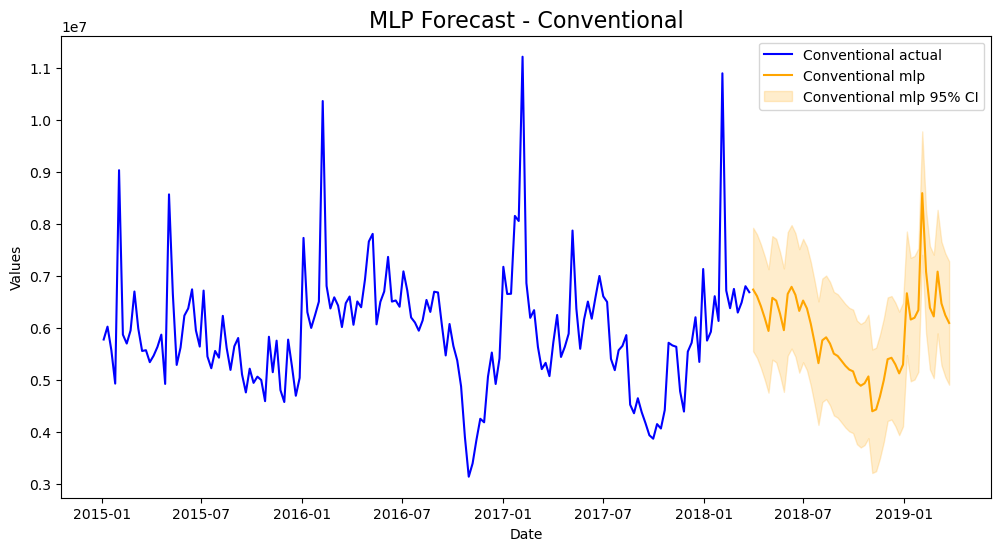

In [37]:
mvf.plot(series='Conventional',models='mlp',ci=True)
plt.title('MLP Forecast - Conventional',size=16)
plt.show()

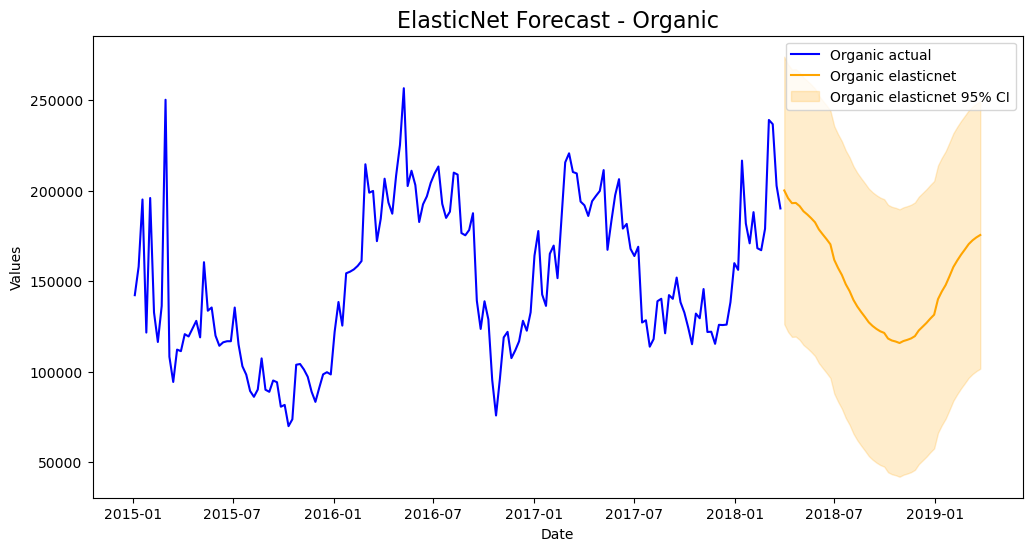

In [38]:
mvf.plot(series='Organic',models='elasticnet',ci=True)
plt.title('ElasticNet Forecast - Organic',size=16)
plt.show()

All-in-all, better results on the test-set were obtained by using the multivariate approach, considering the top-performing models only. Considering the average errors of all models, the univariate may have been the superior approach.

## Multivariate Backtest

Just like in univariate modeling, we can backtest the results of this modeling approach using backtesting.

In [44]:
from scalecast.Pipeline import Transformer, Reverter, MVPipeline
from scalecast.util import backtest_metrics

def add_Xvars(f):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        irr_cycles = [26], # try irregular semi-annual seaosnality
    )

def mvforecaster(mvf):
    mvf.tune_test_forecast(
        models=['elasticnet','xgboost'],
        limit_grid_size=.2,
    )

pipeline = MVPipeline(
    steps = [
        ('Add Xvars',[add_Xvars,add_Xvars]), # call once for each series
        ('Forecast',mvforecaster),
    ],
    validation_length = 4,
)

In [45]:
backtest_results = pipeline.backtest(
    fcon,
    forg,
    cis=False,
    test_length = 0,
    fcst_length = 52,
    jump_back = 4,
    n_iter = 3,
)

In [46]:
backtest_metrics(
    backtest_results,
    mets=['rmse','r2'],
    names=['Conventional','Organic'],
)

Iter0        Iter1        Iter2  \
Series       Model      Metric                                          
Conventional elasticnet rmse   1515461.0234 1185960.1787 1234568.9442   
                        r2          -0.6876      -0.0600      -0.1035   
             xgboost    rmse   1099556.7963  904741.2908 1201685.4025   
                        r2           0.1116       0.3831      -0.0455   
Organic      elasticnet rmse     53679.8618   44616.5763   39673.2262   
                        r2          -1.5918      -0.9607      -0.4793   
             xgboost    rmse     35533.2543   27975.9382   33419.6963   
                        r2          -0.1357       0.2291      -0.0497   

                                    Average  
Series       Model      Metric               
Conventional elasticnet rmse   1311996.7154  
                        r2          -0.2837  
             xgboost    rmse   1068661.1632  
                        r2           0.1497  
Organic      elasticnet rmse     45989.8881  
                        r2          -1.0106  
             xgboost    rmse     32309.6296  
                        r2           0.0146